In [1]:
import numpy as np
from skimage import data
import matplotlib.pyplot as plt
from PIL import Image

from skimage import data
import matplotlib.pyplot as plt
import cv2


In [2]:
img = data.astronaut()

In [3]:
flat_img = img.flatten()

(-0.5, 511.5, 511.5, -0.5)

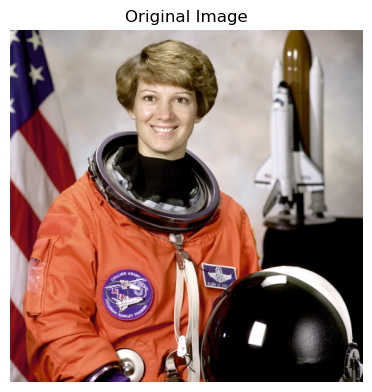

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

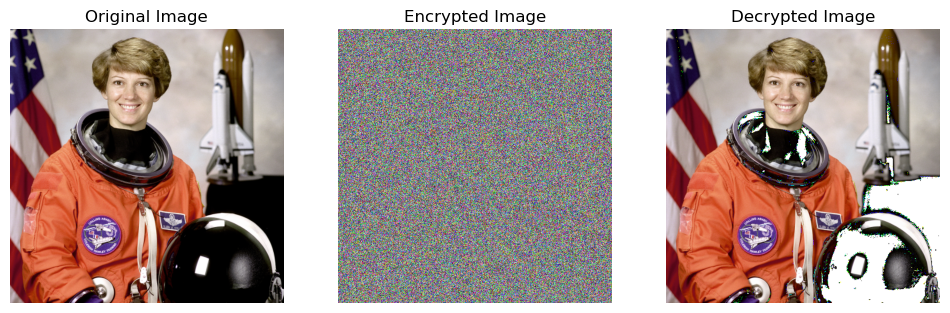

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Logistic Map Generator
def logistic_map(x0, r, size):
    sequence = np.zeros(size)
    sequence[0] = x0
    for i in range(1, size):
        sequence[i] = r * sequence[i - 1] * (1 - sequence[i - 1])
    return sequence

# Image Encryption Function
def encrypt_image(image, x0, r):
    rows, cols, channels = image.shape
    total_pixels = rows * cols * channels

    # Generate chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Create index for shuffling (Confusion)
    shuffled_indices = np.argsort(chaotic_sequence)

    # Flatten image for easy processing
    flat_image = image.flatten()

    # Apply confusion (pixel shuffling)
    shuffled_image = flat_image[shuffled_indices]

    # Diffusion: Modify pixel values using chaotic sequence
    diffused_image = (shuffled_image + (chaotic_sequence * 255)) % 256
    diffused_image = diffused_image.astype(np.uint8)

    # Reshape to original image dimensions
    encrypted_image = diffused_image.reshape((rows, cols, channels))
    return encrypted_image, shuffled_indices

# Image Decryption Function
def decrypt_image(encrypted_image, shuffled_indices, x0, r):
    rows, cols, channels = encrypted_image.shape
    total_pixels = rows * cols * channels

    # Regenerate the same chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Flatten encrypted image
    flat_encrypted = encrypted_image.flatten()

    # Reverse diffusion
    recovered_diffused = (flat_encrypted - (chaotic_sequence * 255)) % 256

    # Reverse confusion (unshuffle pixels)
    unshuffled_image = np.zeros(total_pixels)
    unshuffled_image[shuffled_indices] = recovered_diffused

    # Reshape to original image
    decrypted_image = unshuffled_image.reshape((rows, cols, channels)).astype(np.uint8)
    return decrypted_image

# Load image
img = data.astronaut()
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Encryption parameters
x0 = 0.7  # Initial condition
r = 3.99  # Control parameter
size=int(len(flat_img)/4)
rows, cols, channels = img.shape
total_pixels = rows * cols * channels  # Example: 512*512*3 = 786432

# Generate logistic chaotic sequence of required size
key_sequence = logistic_map(x0, r, total_pixels)

# Convert to key in range [0, 255]
key = np.floor(key_sequence * 256).astype(np.uint8)

# Flatten image
flat_img = img.flatten()
# Encrypt the image
encrypted_image, indices = encrypt_image(img, x0, r)

# Decrypt the image
decrypted_image = decrypt_image(encrypted_image, indices, x0, r)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Encrypted Image')
plt.imshow(encrypted_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Decrypted Image')
plt.imshow(decrypted_image)
plt.axis('off')

plt.show()


In [6]:
import math
from collections import Counter

def calculate_entropy_from_array(img_array):
    def entropy(channel_data):
        flat = channel_data.flatten()
        counts = Counter(flat)
        total = len(flat)
        return -sum((count / total) * math.log2(count / total) for count in counts.values())

    if img_array.ndim == 2:  # Grayscale image
        ent = entropy(img_array)
        print(f"Entropy: {ent:.4f} bits")
    elif img_array.ndim == 3 and img_array.shape[2] == 3:  # RGB image
        r_ent = entropy(img_array[:, :, 0])
        g_ent = entropy(img_array[:, :, 1])
        b_ent = entropy(img_array[:, :, 2])
        print(f"Red Channel Entropy   : {r_ent:.4f} bits")
        print(f"Green Channel Entropy : {g_ent:.4f} bits")
        print(f"Blue Channel Entropy  : {b_ent:.4f} bits")
        avg_ent = (r_ent + g_ent + b_ent) / 3
        print(f"Average Entropy       : {avg_ent:.4f} bits")
    else:
        raise ValueError("Unsupported image format")


# After XOR encryption:
# encrypted_img = encrypted_flat.reshape(img.shape)
calculate_entropy_from_array(encrypted_image)


Red Channel Entropy   : 7.9922 bits
Green Channel Entropy : 7.9925 bits
Blue Channel Entropy  : 7.9923 bits
Average Entropy       : 7.9923 bits


In [7]:
from math import log10

def calculate_npcr(img1, img2):
    return np.sum(img1 != img2) / img1.size * 100

def calculate_uaci(img1, img2):
    diff = np.abs(img1.astype(np.int32) - img2.astype(np.int32))
    return np.mean(diff / 255.0) * 100

def calculate_psnr(img1, img2):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf'), mse
    psnr = 10 * log10((255.0 ** 2) / mse)
    return psnr, mse

def evaluate_encryption_metrics(img, encrypted_img):
    if img.ndim == 3:  # RGB image
        npcr_total, uaci_total, psnr_total, mse_total = 0, 0, 0, 0
        for c in range(3):
            npcr = calculate_npcr(img[:, :, c], encrypted_img[:, :, c])
            uaci = calculate_uaci(img[:, :, c], encrypted_img[:, :, c])
            psnr, mse = calculate_psnr(img[:, :, c], encrypted_img[:, :, c])
            print(f"Channel {c} - NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB, MSE: {mse:.2f}")
            npcr_total += npcr
            uaci_total += uaci
            psnr_total += psnr
            mse_total += mse
        print(f"Average - NPCR: {npcr_total/3:.2f}%, UACI: {uaci_total/3:.2f}%, PSNR: {psnr_total/3:.2f} dB, MSE: {mse_total/3:.2f}")
    else:  # Grayscale
        npcr = calculate_npcr(img, encrypted_img)
        uaci = calculate_uaci(img, encrypted_img)
        psnr, mse = calculate_psnr(img, encrypted_img)
        print(f"NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB, MSE: {mse:.2f}")
# evaluate_encryption_metrics(original_img, encrypted_img)
evaluate_encryption_metrics(img, encrypted_image)

Channel 0 - NPCR: 99.60%, UACI: 35.83%, PSNR: 7.13 dB, MSE: 12597.76
Channel 1 - NPCR: 99.61%, UACI: 35.37%, PSNR: 7.26 dB, MSE: 12210.29
Channel 2 - NPCR: 99.60%, UACI: 36.48%, PSNR: 7.02 dB, MSE: 12928.38
Average - NPCR: 99.60%, UACI: 35.89%, PSNR: 7.14 dB, MSE: 12578.81


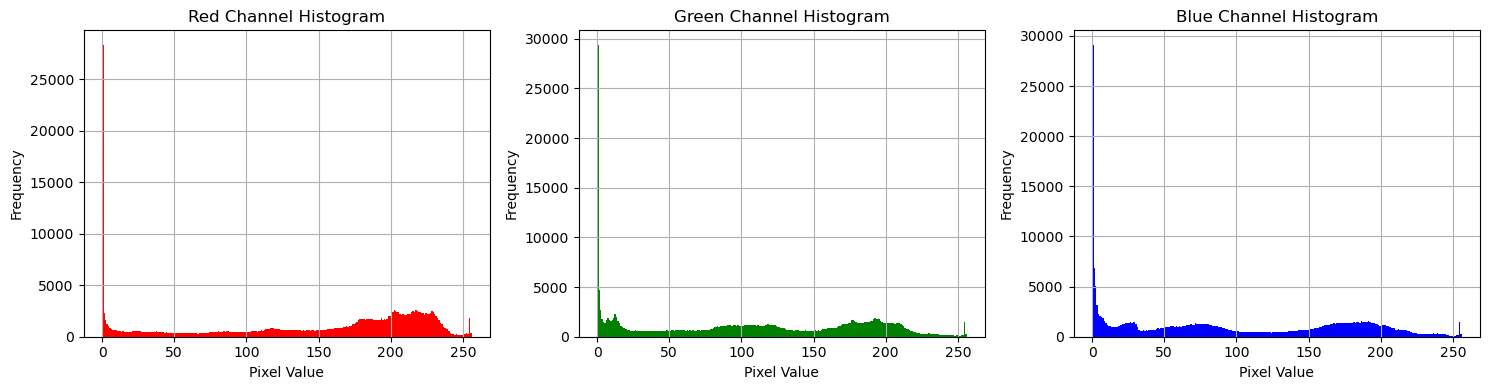

In [8]:
import matplotlib.pyplot as plt
from skimage import data

# Load the sample image
img = data.astronaut()  # shape: (512, 512, 3)

# Split the image into R, G, B channels
r_channel = img[:, :, 0]
g_channel = img[:, :, 1]
b_channel = img[:, :, 2]

# Create subplots
plt.figure(figsize=(15, 4))

# Red channel histogram
plt.subplot(1, 3, 1)
plt.hist(r_channel.ravel(), bins=256, range=[0, 256], color='red')
plt.title("Red Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Green channel histogram
plt.subplot(1, 3, 2)
plt.hist(g_channel.ravel(), bins=256, range=[0, 256], color='green')
plt.title("Green Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Blue channel histogram
plt.subplot(1, 3, 3)
plt.hist(b_channel.ravel(), bins=256, range=[0, 256], color='blue')
plt.title("Blue Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Show all plots
plt.tight_layout()
plt.show()




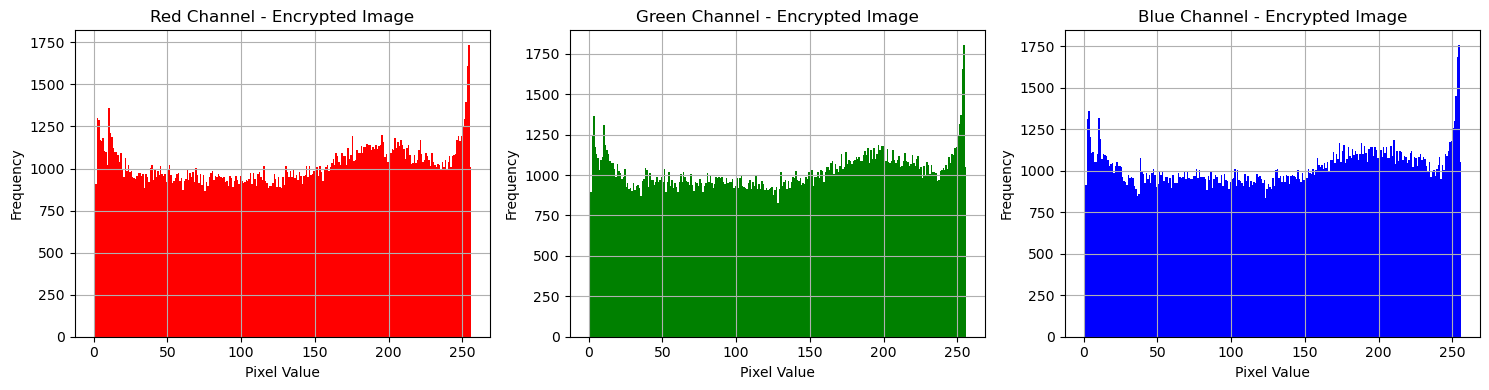

In [9]:
# Split the encrypted image into R, G, B channels
r_enc =  encrypted_image[:, :, 0]
g_enc =  encrypted_image[:, :, 1]
b_enc =  encrypted_image[:, :, 2]

# Create subplots for each channel
plt.figure(figsize=(15, 4))

# Red channel histogram
plt.subplot(1, 3, 1)
plt.hist(r_enc.ravel(), bins=256, range=[0, 256], color='red')
plt.title("Red Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Green channel histogram
plt.subplot(1, 3, 2)
plt.hist(g_enc.ravel(), bins=256, range=[0, 256], color='green')
plt.title("Green Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Blue channel histogram
plt.subplot(1, 3, 3)
plt.hist(b_enc.ravel(), bins=256, range=[0, 256], color='blue')
plt.title("Blue Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()

# cameraman image

In [10]:
img = data.camera()

In [11]:
flat_img = img.flatten()

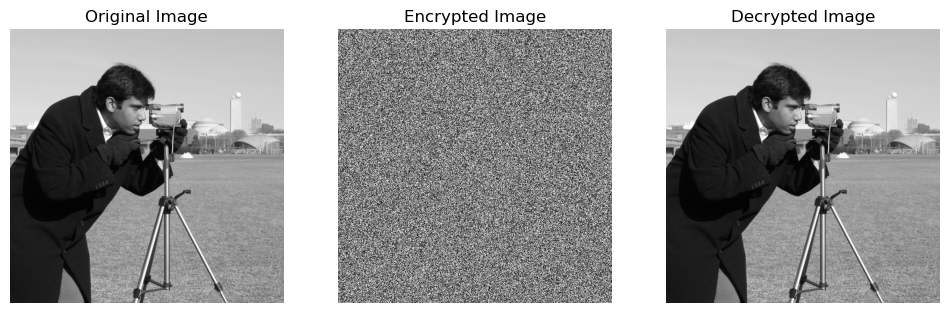

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Logistic Map Generator
def logistic_map(x0, r, size):
    sequence = np.zeros(size)
    sequence[0] = x0
    for i in range(1, size):
        sequence[i] = r * sequence[i - 1] * (1 - sequence[i - 1])
    return sequence

# Image Encryption Function
def encrypt_image(img, x0, r):
    rows, cols = img.shape
    total_pixels = rows * cols

    # Generate chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Create index for shuffling (Confusion)
    shuffled_indices = np.argsort(chaotic_sequence)

    # Flatten image for easy processing
    flat_img = img.flatten()

    # Apply confusion (pixel shuffling)
    shuffled_img = flat_img[shuffled_indices]

    # Diffusion: Modify pixel values using chaotic sequence
    key = np.floor(chaotic_sequence * 256).astype(np.uint8)
    diffused_img = np.bitwise_xor(shuffled_img, key)

    # Reshape to original image dimensions
    encrypted_img = diffused_img.reshape((rows, cols))
    return encrypted_img, shuffled_indices

# Image Decryption Function
def decrypt_image(encrypted_img, shuffled_indices, x0, r):
    rows, cols = encrypted_img.shape
    total_pixels = rows * cols

    # Regenerate the same chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Flatten encrypted image
    flat_encrypted = encrypted_img.flatten()

    # Reverse diffusion
    key = np.floor(chaotic_sequence * 256).astype(np.uint8)
    recovered_diffused = np.bitwise_xor(flat_encrypted, key)

    # Reverse confusion (unshuffle pixels)
    unshuffled_img = np.zeros(total_pixels, dtype=np.uint8)
    unshuffled_img[shuffled_indices] = recovered_diffused

    # Reshape to original image
    decrypted_img = unshuffled_img.reshape((rows, cols))
    return decrypted_img


# Encryption parameters
x0 = 0.7  # Initial condition
r = 3.99  # Control parameter

# Encrypt the image
encrypted_img, indices = encrypt_image(img, x0, r)

# Decrypt the image
decrypted_img = decrypt_image(encrypted_img, indices, x0, r)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Encrypted Image')
plt.imshow(encrypted_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Decrypted Image')
plt.imshow(decrypted_img, cmap='gray')
plt.axis('off')

plt.show()


In [13]:
def calculate_entropy_from_array(img_array):
    def entropy(channel_data):
        flat = channel_data.flatten()
        counts = Counter(flat)
        total = len(flat)
        return -sum((count / total) * math.log2(count / total) for count in counts.values())

    if img_array.ndim == 2:  # Grayscale image
        ent = entropy(img_array)
        print(f"Entropy: {ent:.4f} bits")
    elif img_array.ndim == 3 and img_array.shape[2] == 3:  # RGB image
        r_ent = entropy(img_array[:, :, 0])
        g_ent = entropy(img_array[:, :, 1])
        b_ent = entropy(img_array[:, :, 2])
        print(f"Red Channel Entropy   : {r_ent:.4f} bits")
        print(f"Green Channel Entropy : {g_ent:.4f} bits")
        print(f"Blue Channel Entropy  : {b_ent:.4f} bits")
        avg_ent = (r_ent + g_ent + b_ent) / 3
        print(f"Average Entropy       : {avg_ent:.4f} bits")
    else:
        raise ValueError("Unsupported image format")

# After XOR encryption:
# encrypted_img = encrypted_flat.reshape(img.shape)
calculate_entropy_from_array(encrypted_img)

Entropy: 7.9911 bits


In [14]:
def calculate_npcr(img1, img2):
    return np.sum(img1 != img2) / img1.size * 100

def calculate_uaci(img1, img2):
    diff = np.abs(img1.astype(np.int32) - img2.astype(np.int32))
    return np.mean(diff / 255.0) * 100

def calculate_psnr(img1, img2):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * log10((255.0 ** 2) / mse)



def evaluate_encryption_metrics(img, encrypted_img):
    if img.ndim == 3:  # RGB image
        npcr_total, uaci_total, psnr_total = 0, 0, 0
        for c in range(3):
            npcr = calculate_npcr(img[:, :, c], encrypted_img[:, :, c])
            uaci = calculate_uaci(img[:, :, c], encrypted_img[:, :, c])
            psnr = calculate_psnr(img[:, :, c], encrypted_img[:, :, c])
            print(f"Channel {c} - NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB")
            npcr_total += npcr
            uaci_total += uaci
            psnr_total += psnr
        print(f"Average - NPCR: {npcr_total/3:.2f}%, UACI: {uaci_total/3:.2f}%, PSNR: {psnr_total/3:.2f} dB")
    else:  # Grayscale
        npcr = calculate_npcr(img, encrypted_img)
        uaci = calculate_uaci(img, encrypted_img)
        psnr = calculate_psnr(img, encrypted_img)
        print(f"NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB")
img=data.camera()
encrypted_img, indices = encrypt_image(img, x0, r)
# evaluate_encryption_metrics(original_img, encrypted_img)
evaluate_encryption_metrics(img, encrypted_img)

NPCR: 99.62%, UACI: 33.59%, PSNR: 7.73 dB


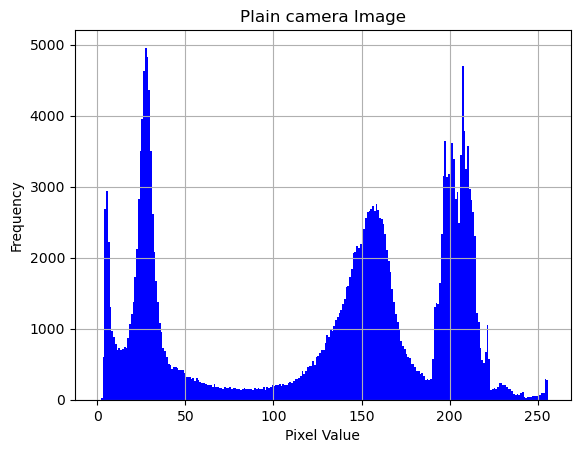

In [15]:
plt.hist(img.ravel(), bins=256, range=[0, 256], color='blue')
plt.title("Plain camera Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

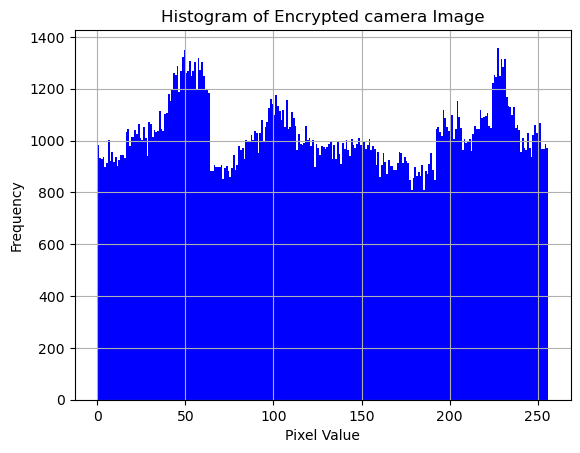

In [16]:
plt.hist(encrypted_img.ravel(), bins=256, range=[0, 256], color='blue')
plt.title("Histogram of Encrypted camera Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Coffee

In [17]:
img=data.coffee()

In [18]:
flat_img = img.flatten()

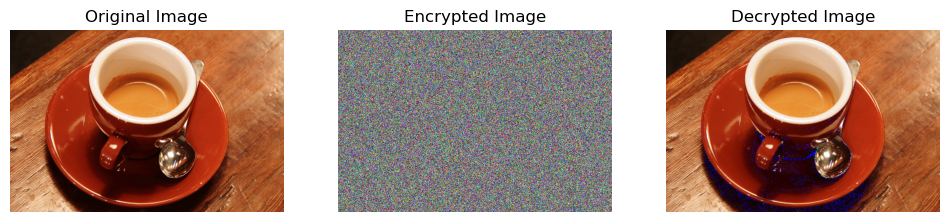

In [19]:
# Logistic Map Generator
def logistic_map(x0, r, size):
    sequence = np.zeros(size)
    sequence[0] = x0
    for i in range(1, size):
        sequence[i] = r * sequence[i - 1] * (1 - sequence[i - 1])
    return sequence

# Image Encryption Function
def encrypt_image(image, x0, r):
    rows, cols, channels = image.shape
    total_pixels = rows * cols * channels

    # Generate chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Create index for shuffling (Confusion)
    shuffled_indices = np.argsort(chaotic_sequence)

    # Flatten image for easy processing
    flat_image = image.flatten()

    # Apply confusion (pixel shuffling)
    shuffled_image = flat_image[shuffled_indices]

    # Diffusion: Modify pixel values using chaotic sequence
    diffused_image = (shuffled_image + (chaotic_sequence * 255)) % 256
    diffused_image = diffused_image.astype(np.uint8)

    # Reshape to original image dimensions
    encrypted_image = diffused_image.reshape((rows, cols, channels))
    return encrypted_image, shuffled_indices

# Image Decryption Function
def decrypt_image(encrypted_image, shuffled_indices, x0, r):
    rows, cols, channels = encrypted_image.shape
    total_pixels = rows * cols * channels

    # Regenerate the same chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Flatten encrypted image
    flat_encrypted = encrypted_image.flatten()

    # Reverse diffusion
    recovered_diffused = (flat_encrypted - (chaotic_sequence * 255)) % 256

    # Reverse confusion (unshuffle pixels)
    unshuffled_image = np.zeros(total_pixels)
    unshuffled_image[shuffled_indices] = recovered_diffused

    # Reshape to original image
    decrypted_image = unshuffled_image.reshape((rows, cols, channels)).astype(np.uint8)
    return decrypted_image


#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Encryption parameters
x0 = 0.7  # Initial condition
r = 3.99  # Control parameter
size=int(len(flat_img)/4)
rows, cols, channels = img.shape
total_pixels = rows * cols * channels  # Example: 512*512*3 = 786432

# Generate logistic chaotic sequence of required size
key_sequence = logistic_map(x0, r, total_pixels)

# Convert to key in range [0, 255]
key = np.floor(key_sequence * 256).astype(np.uint8)

# Flatten image
flat_img = img.flatten()
# Encrypt the image
encrypted_image, indices = encrypt_image(img, x0, r)

# Decrypt the image
decrypted_image = decrypt_image(encrypted_image, indices, x0, r)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Encrypted Image')
plt.imshow(encrypted_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Decrypted Image')
plt.imshow(decrypted_image)
plt.axis('off')

plt.show()



In [20]:
def calculate_entropy_from_array(img_array):
    def entropy(channel_data):
        flat = channel_data.flatten()
        counts = Counter(flat)
        total = len(flat)
        return -sum((count / total) * math.log2(count / total) for count in counts.values())

    if img_array.ndim == 2:  # Grayscale image
        ent = entropy(img_array)
        print(f"Entropy: {ent:.4f} bits")
    elif img_array.ndim == 3 and img_array.shape[2] == 3:  # RGB image
        r_ent = entropy(img_array[:, :, 0])
        g_ent = entropy(img_array[:, :, 1])
        b_ent = entropy(img_array[:, :, 2])
        print(f"Red Channel Entropy   : {r_ent:.4f} bits")
        print(f"Green Channel Entropy : {g_ent:.4f} bits")
        print(f"Blue Channel Entropy  : {b_ent:.4f} bits")
        avg_ent = (r_ent + g_ent + b_ent) / 3
        print(f"Average Entropy       : {avg_ent:.4f} bits")
    else:
        raise ValueError("Unsupported image format")


# After XOR encryption:
# encrypted_img = encrypted_flat.reshape(img.shape)
calculate_entropy_from_array(encrypted_image)

Red Channel Entropy   : 7.9947 bits
Green Channel Entropy : 7.9945 bits
Blue Channel Entropy  : 7.9946 bits
Average Entropy       : 7.9946 bits


In [21]:
import numpy as np
import cv2
from math import log10

def calculate_npcr(img1, img2):
    return np.sum(img1 != img2) / img1.size * 100

def calculate_uaci(img1, img2):
    diff = np.abs(img1.astype(np.int32) - img2.astype(np.int32))
    return np.mean(diff / 255.0) * 100

def calculate_psnr(img1, img2):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * log10((255.0 ** 2) / mse)



def evaluate_encryption_metrics(img, encrypted_img):
    if img.ndim == 3:  # RGB image
        npcr_total, uaci_total, psnr_total = 0, 0, 0
        for c in range(3):
            npcr = calculate_npcr(img[:, :, c], encrypted_img[:, :, c])
            uaci = calculate_uaci(img[:, :, c], encrypted_img[:, :, c])
            psnr = calculate_psnr(img[:, :, c], encrypted_img[:, :, c])
            print(f"Channel {c} - NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB")
            npcr_total += npcr
            uaci_total += uaci
            psnr_total += psnr
        print(f"Average - NPCR: {npcr_total/3:.2f}%, UACI: {uaci_total/3:.2f}%, PSNR: {psnr_total/3:.2f} dB")
    else:  # Grayscale
        npcr = calculate_npcr(img, encrypted_img)
        uaci = calculate_uaci(img, encrypted_img)
        psnr = calculate_psnr(img, encrypted_img)
        print(f"NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB")


# evaluate_encryption_metrics(original_img, encrypted_img)
evaluate_encryption_metrics(img, encrypted_image)

Channel 0 - NPCR: 99.61%, UACI: 33.59%, PSNR: 7.75 dB
Channel 1 - NPCR: 99.60%, UACI: 33.19%, PSNR: 7.79 dB
Channel 2 - NPCR: 99.58%, UACI: 37.34%, PSNR: 6.78 dB
Average - NPCR: 99.60%, UACI: 34.71%, PSNR: 7.44 dB


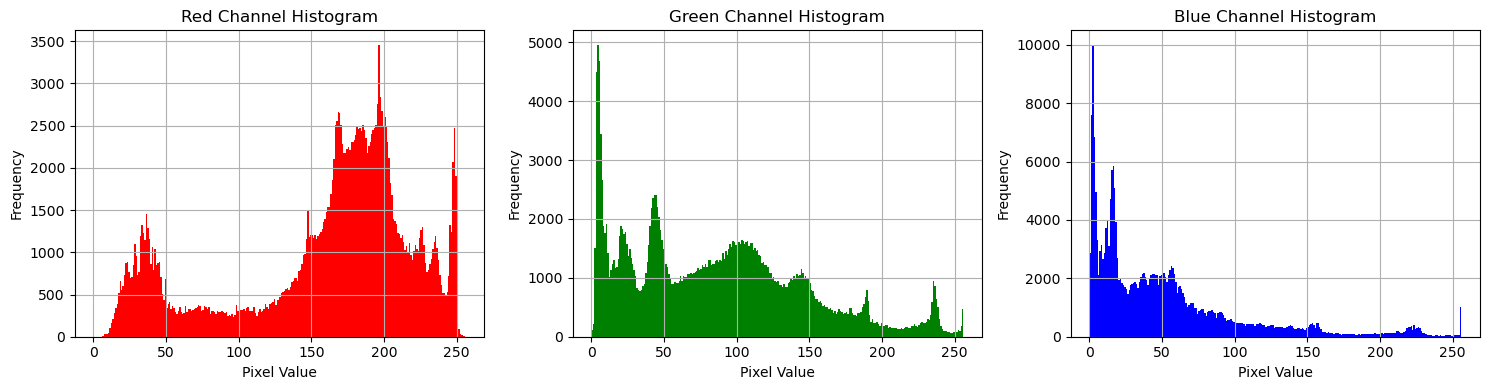

In [22]:
import matplotlib.pyplot as plt
from skimage import data

# Load the sample image
 # shape: (512, 512, 3)

# Split the image into R, G, B channels
r_channel = img[:, :, 0]
g_channel = img[:, :, 1]
b_channel = img[:, :, 2]

# Create subplots
plt.figure(figsize=(15, 4))

# Red channel histogram
plt.subplot(1, 3, 1)
plt.hist(r_channel.ravel(), bins=256, range=[0, 256], color='red')
plt.title("Red Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Green channel histogram
plt.subplot(1, 3, 2)
plt.hist(g_channel.ravel(), bins=256, range=[0, 256], color='green')
plt.title("Green Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Blue channel histogram
plt.subplot(1, 3, 3)
plt.hist(b_channel.ravel(), bins=256, range=[0, 256], color='blue')
plt.title("Blue Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Show all plots
plt.tight_layout()
plt.show()



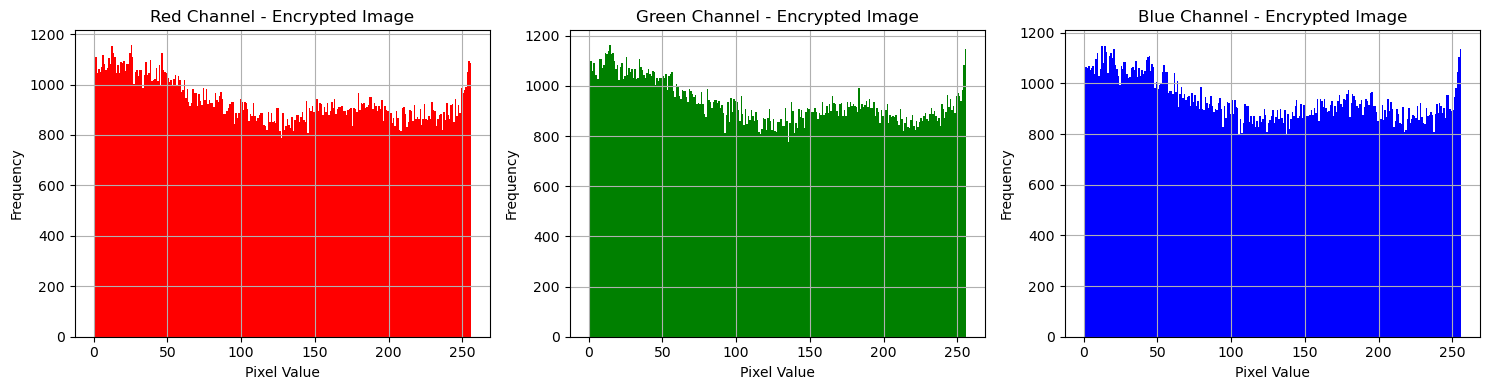

In [23]:
# Split the encrypted image into R, G, B channels
r_enc =  encrypted_image[:, :, 0]
g_enc =  encrypted_image[:, :, 1]
b_enc =  encrypted_image[:, :, 2]

# Create subplots for each channel
plt.figure(figsize=(15, 4))

# Red channel histogram
plt.subplot(1, 3, 1)
plt.hist(r_enc.ravel(), bins=256, range=[0, 256], color='red')
plt.title("Red Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Green channel histogram
plt.subplot(1, 3, 2)
plt.hist(g_enc.ravel(), bins=256, range=[0, 256], color='green')
plt.title("Green Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Blue channel histogram
plt.subplot(1, 3, 3)
plt.hist(b_enc.ravel(), bins=256, range=[0, 256], color='blue')
plt.title("Blue Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()

# Fruits


In [24]:
img=plt.imread("fruits.jpg")

In [25]:
img_flat = img.flatten()

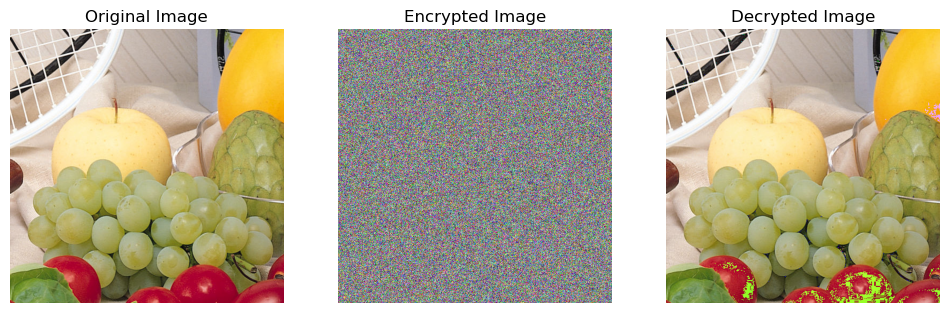

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Logistic Map Generator
def logistic_map(x0, r, size):
    sequence = np.zeros(size)
    sequence[0] = x0
    for i in range(1, size):
        sequence[i] = r * sequence[i - 1] * (1 - sequence[i - 1])
    return sequence

# Image Encryption Function
def encrypt_image(image, x0, r):
    rows, cols, channels = image.shape
    total_pixels = rows * cols * channels

    # Generate chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Create index for shuffling (Confusion)
    shuffled_indices = np.argsort(chaotic_sequence)

    # Flatten image for easy processing
    flat_image = image.flatten()

    # Apply confusion (pixel shuffling)
    shuffled_image = flat_image[shuffled_indices]

    # Diffusion: Modify pixel values using chaotic sequence
    diffused_image = (shuffled_image + (chaotic_sequence * 255)) % 256
    diffused_image = diffused_image.astype(np.uint8)

    # Reshape to original image dimensions
    encrypted_image = diffused_image.reshape((rows, cols, channels))
    return encrypted_image, shuffled_indices

# Image Decryption Function
def decrypt_image(encrypted_image, shuffled_indices, x0, r):
    rows, cols, channels = encrypted_image.shape
    total_pixels = rows * cols * channels

    # Regenerate the same chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Flatten encrypted image
    flat_encrypted = encrypted_image.flatten()

    # Reverse diffusion
    recovered_diffused = (flat_encrypted - (chaotic_sequence * 255)) % 256

    # Reverse confusion (unshuffle pixels)
    unshuffled_image = np.zeros(total_pixels)
    unshuffled_image[shuffled_indices] = recovered_diffused

    # Reshape to original image
    decrypted_image = unshuffled_image.reshape((rows, cols, channels)).astype(np.uint8)
    return decrypted_image
img=plt.imread("fruits.jpg")
x0 = 0.7  # Initial condition
r = 3.99  # Control parameter
size=int(len(img_flat)/4)
rows, cols, channels = img.shape
total_pixels = rows * cols * channels  # Example: 512*512*3 = 786432

# Generate logistic chaotic sequence of required size
key_sequence = logistic_map(x0, r, total_pixels)

# Convert to key in range [0, 255]
key = np.floor(key_sequence * 256).astype(np.uint8)

# Flatten image
flat_img = img.flatten()
# Encrypt the image
encrypted_image, indices = encrypt_image(img, x0, r)

# Decrypt the image
decrypted_image = decrypt_image(encrypted_image, indices, x0, r)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Encrypted Image')
plt.imshow(encrypted_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Decrypted Image')
plt.imshow(decrypted_image)
plt.axis('off')

plt.show()


In [27]:
import numpy as np
import math
from collections import Counter

def calculate_entropy_from_array(img_array):
    def entropy(channel_data):
        flat = channel_data.flatten()
        counts = Counter(flat)
        total = len(flat)
        return -sum((count / total) * math.log2(count / total) for count in counts.values())

    if img_array.ndim == 2:  # Grayscale image
        ent = entropy(img_array)
        print(f"Entropy: {ent:.4f} bits")
    elif img_array.ndim == 3 and img_array.shape[2] == 3:  # RGB image
        r_ent = entropy(img_array[:, :, 0])
        g_ent = entropy(img_array[:, :, 1])
        b_ent = entropy(img_array[:, :, 2])
        print(f"Red Channel Entropy   : {r_ent:.4f} bits")
        print(f"Green Channel Entropy : {g_ent:.4f} bits")
        print(f"Blue Channel Entropy  : {b_ent:.4f} bits")
        avg_ent = (r_ent + g_ent + b_ent) / 3
        print(f"Average Entropy       : {avg_ent:.4f} bits")
    else:
        raise ValueError("Unsupported image format")


# After XOR encryption:
# encrypted_img = encrypted_flat.reshape(img.shape)
calculate_entropy_from_array(encrypted_image)

Red Channel Entropy   : 7.9856 bits
Green Channel Entropy : 7.9864 bits
Blue Channel Entropy  : 7.9858 bits
Average Entropy       : 7.9859 bits


In [28]:
import numpy as np
import cv2
from math import log10

def calculate_npcr(img1, img2):
    return np.sum(img1 != img2) / img1.size * 100

def calculate_uaci(img1, img2):
    diff = np.abs(img1.astype(np.int32) - img2.astype(np.int32))
    return np.mean(diff / 255.0) * 100

def calculate_psnr(img1, img2):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf'), mse
    psnr = 10 * log10((255.0 ** 2) / mse)
    return psnr, mse

def evaluate_encryption_metrics(img, encrypted_img):
    if img.ndim == 3:  # RGB image
        npcr_total, uaci_total, psnr_total, mse_total = 0, 0, 0, 0
        for c in range(3):
            npcr = calculate_npcr(img[:, :, c], encrypted_img[:, :, c])
            uaci = calculate_uaci(img[:, :, c], encrypted_img[:, :, c])
            psnr, mse = calculate_psnr(img[:, :, c], encrypted_img[:, :, c])
            print(f"Channel {c} - NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB, MSE: {mse:.2f}")
            npcr_total += npcr
            uaci_total += uaci
            psnr_total += psnr
            mse_total += mse
        print(f"Average - NPCR: {npcr_total/3:.2f}%, UACI: {uaci_total/3:.2f}%, PSNR: {psnr_total/3:.2f} dB, MSE: {mse_total/3:.2f}")
    else:  # Grayscale
        npcr = calculate_npcr(img, encrypted_img)
        uaci = calculate_uaci(img, encrypted_img)
        psnr, mse = calculate_psnr(img, encrypted_img)
        print(f"NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB, MSE: {mse:.2f}")

# Example usage:
# evaluate_encryption_metrics(original_img, encrypted_img)
evaluate_encryption_metrics(img, encrypted_image)


Channel 0 - NPCR: 99.56%, UACI: 31.73%, PSNR: 8.09 dB, MSE: 10094.41
Channel 1 - NPCR: 99.56%, UACI: 30.36%, PSNR: 8.49 dB, MSE: 9214.99
Channel 2 - NPCR: 99.61%, UACI: 30.41%, PSNR: 8.62 dB, MSE: 8933.54
Average - NPCR: 99.58%, UACI: 30.83%, PSNR: 8.40 dB, MSE: 9414.31


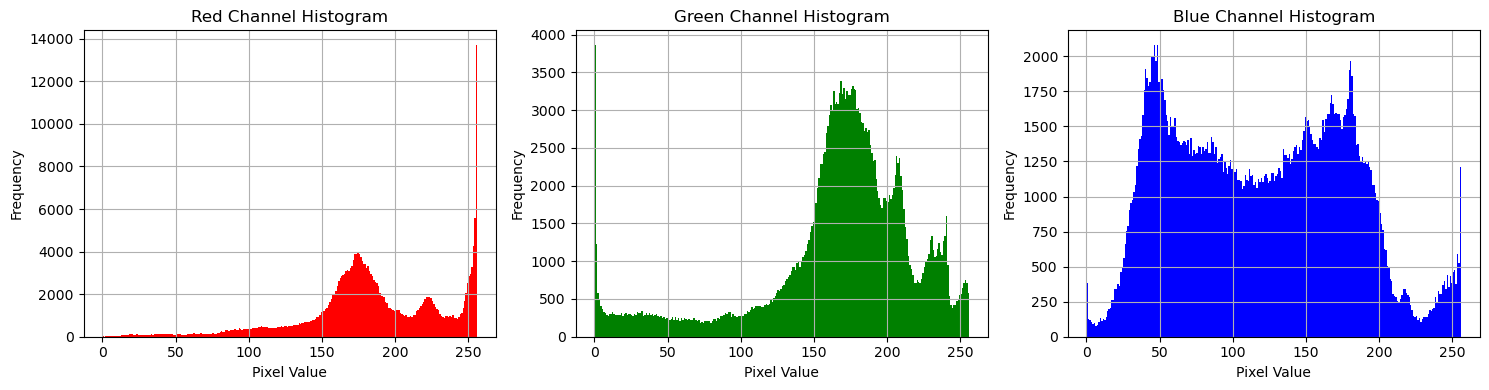

In [29]:
import matplotlib.pyplot as plt
from skimage import data

# Load the sample image
img=plt.imread("fruits.jpg") # shape: (512, 512, 3)

# Split the image into R, G, B channels
r_channel = img[:, :, 0]
g_channel = img[:, :, 1]
b_channel = img[:, :, 2]

# Create subplots
plt.figure(figsize=(15, 4))

# Red channel histogram
plt.subplot(1, 3, 1)
plt.hist(r_channel.ravel(), bins=256, range=[0, 256], color='red')
plt.title("Red Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Green channel histogram
plt.subplot(1, 3, 2)
plt.hist(g_channel.ravel(), bins=256, range=[0, 256], color='green')
plt.title("Green Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Blue channel histogram
plt.subplot(1, 3, 3)
plt.hist(b_channel.ravel(), bins=256, range=[0, 256], color='blue')
plt.title("Blue Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Show all plots
plt.tight_layout()
plt.show()



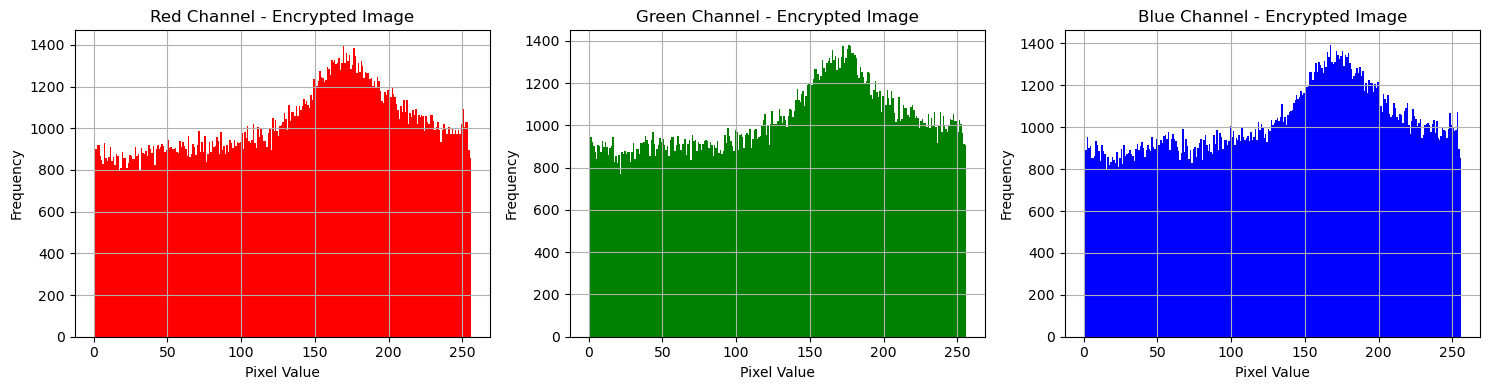

In [30]:
# Split the encrypted image into R, G, B channels
r_enc =  encrypted_image[:, :, 0]
g_enc =  encrypted_image[:, :, 1]
b_enc =  encrypted_image[:, :, 2]

# Create subplots for each channel
plt.figure(figsize=(15, 4))

# Red channel histogram
plt.subplot(1, 3, 1)
plt.hist(r_enc.ravel(), bins=256, range=[0, 256], color='red')
plt.title("Red Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Green channel histogram
plt.subplot(1, 3, 2)
plt.hist(g_enc.ravel(), bins=256, range=[0, 256], color='green')
plt.title("Green Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Blue channel histogram
plt.subplot(1, 3, 3)
plt.hist(b_enc.ravel(), bins=256, range=[0, 256], color='blue')
plt.title("Blue Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()

# Pepper

In [31]:
img=plt.imread("peppers.jpg")

In [32]:
img_flat = img.flatten()

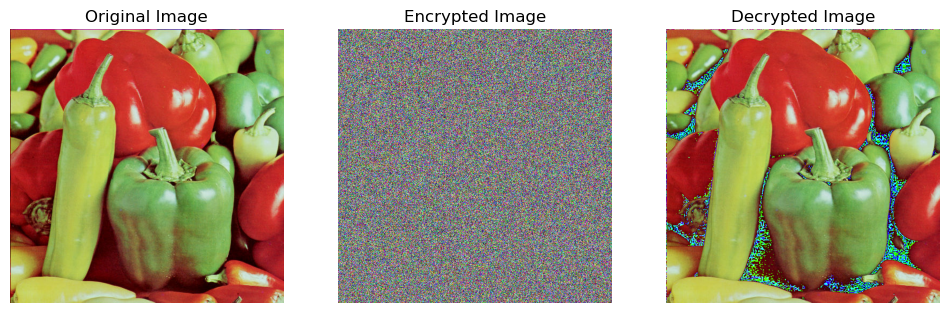

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Logistic Map Generator
def logistic_map(x0, r, size):
    sequence = np.zeros(size)
    sequence[0] = x0
    for i in range(1, size):
        sequence[i] = r * sequence[i - 1] * (1 - sequence[i - 1])
    return sequence

# Image Encryption Function
def encrypt_image(image, x0, r):
    rows, cols, channels = image.shape
    total_pixels = rows * cols * channels

    # Generate chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Create index for shuffling (Confusion)
    shuffled_indices = np.argsort(chaotic_sequence)

    # Flatten image for easy processing
    flat_image = image.flatten()

    # Apply confusion (pixel shuffling)
    shuffled_image = flat_image[shuffled_indices]

    # Diffusion: Modify pixel values using chaotic sequence
    diffused_image = (shuffled_image + (chaotic_sequence * 255)) % 256
    diffused_image = diffused_image.astype(np.uint8)

    # Reshape to original image dimensions
    encrypted_image = diffused_image.reshape((rows, cols, channels))
    return encrypted_image, shuffled_indices

# Image Decryption Function
def decrypt_image(encrypted_image, shuffled_indices, x0, r):
    rows, cols, channels = encrypted_image.shape
    total_pixels = rows * cols * channels

    # Regenerate the same chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Flatten encrypted image
    flat_encrypted = encrypted_image.flatten()

    # Reverse diffusion
    recovered_diffused = (flat_encrypted - (chaotic_sequence * 255)) % 256

    # Reverse confusion (unshuffle pixels)
    unshuffled_image = np.zeros(total_pixels)
    unshuffled_image[shuffled_indices] = recovered_diffused

    # Reshape to original image
    decrypted_image = unshuffled_image.reshape((rows, cols, channels)).astype(np.uint8)
    return decrypted_image

# Load image
img=plt.imread("peppers.jpg")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Encryption parameters
x0 = 0.7  # Initial condition
r = 3.99  # Control parameter
size=int(len(flat_img)/4)
rows, cols, channels = img.shape
total_pixels = rows * cols * channels  # Example: 512*512*3 = 786432

# Generate logistic chaotic sequence of required size
key_sequence = logistic_map(x0, r, total_pixels)

# Convert to key in range [0, 255]
key = np.floor(key_sequence * 256).astype(np.uint8)

# Flatten image
flat_img = img.flatten()
# Encrypt the image
encrypted_image, indices = encrypt_image(img, x0, r)

# Decrypt the image
decrypted_image = decrypt_image(encrypted_image, indices, x0, r)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Encrypted Image')
plt.imshow(encrypted_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Decrypted Image')
plt.imshow(decrypted_image)
plt.axis('off')

plt.show()


In [34]:
import numpy as np
import math
from collections import Counter

def calculate_entropy_from_array(img_array):
    def entropy(channel_data):
        flat = channel_data.flatten()
        counts = Counter(flat)
        total = len(flat)
        return -sum((count / total) * math.log2(count / total) for count in counts.values())

    if img_array.ndim == 2:  # Grayscale image
        ent = entropy(img_array)
        print(f"Entropy: {ent:.4f} bits")
    elif img_array.ndim == 3 and img_array.shape[2] == 3:  # RGB image
        r_ent = entropy(img_array[:, :, 0])
        g_ent = entropy(img_array[:, :, 1])
        b_ent = entropy(img_array[:, :, 2])
        print(f"Red Channel Entropy   : {r_ent:.4f} bits")
        print(f"Green Channel Entropy : {g_ent:.4f} bits")
        print(f"Blue Channel Entropy  : {b_ent:.4f} bits")
        avg_ent = (r_ent + g_ent + b_ent) / 3
        print(f"Average Entropy       : {avg_ent:.4f} bits")
    else:
        raise ValueError("Unsupported image format")


# After XOR encryption:
# encrypted_img = encrypted_flat.reshape(img.shape)
calculate_entropy_from_array(encrypted_image)

Red Channel Entropy   : 7.9953 bits
Green Channel Entropy : 7.9954 bits
Blue Channel Entropy  : 7.9957 bits
Average Entropy       : 7.9955 bits


In [35]:
import numpy as np
import cv2
from math import log10

def calculate_npcr(img1, img2):
    return np.sum(img1 != img2) / img1.size * 100

def calculate_uaci(img1, img2):
    diff = np.abs(img1.astype(np.int32) - img2.astype(np.int32))
    return np.mean(diff / 255.0) * 100

def calculate_psnr(img1, img2):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf'), mse
    psnr = 10 * log10((255.0 ** 2) / mse)
    return psnr, mse

def evaluate_encryption_metrics(img, encrypted_img):
    if img.ndim == 3:  # RGB image
        npcr_total, uaci_total, psnr_total, mse_total = 0, 0, 0, 0
        for c in range(3):
            npcr = calculate_npcr(img[:, :, c], encrypted_img[:, :, c])
            uaci = calculate_uaci(img[:, :, c], encrypted_img[:, :, c])
            psnr, mse = calculate_psnr(img[:, :, c], encrypted_img[:, :, c])
            print(f"Channel {c} - NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB, MSE: {mse:.2f}")
            npcr_total += npcr
            uaci_total += uaci
            psnr_total += psnr
            mse_total += mse
        print(f"Average - NPCR: {npcr_total/3:.2f}%, UACI: {uaci_total/3:.2f}%, PSNR: {psnr_total/3:.2f} dB, MSE: {mse_total/3:.2f}")
    else:  # Grayscale
        npcr = calculate_npcr(img, encrypted_img)
        uaci = calculate_uaci(img, encrypted_img)
        psnr, mse = calculate_psnr(img, encrypted_img)
        print(f"NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB, MSE: {mse:.2f}")

# Example usage:
# evaluate_encryption_metrics(original_img, encrypted_img)
evaluate_encryption_metrics(img, encrypted_image)


Channel 0 - NPCR: 99.61%, UACI: 28.79%, PSNR: 9.15 dB, MSE: 7901.82
Channel 1 - NPCR: 99.60%, UACI: 33.44%, PSNR: 7.75 dB, MSE: 10914.73
Channel 2 - NPCR: 99.59%, UACI: 33.02%, PSNR: 7.84 dB, MSE: 10685.76
Average - NPCR: 99.60%, UACI: 31.75%, PSNR: 8.25 dB, MSE: 9834.11


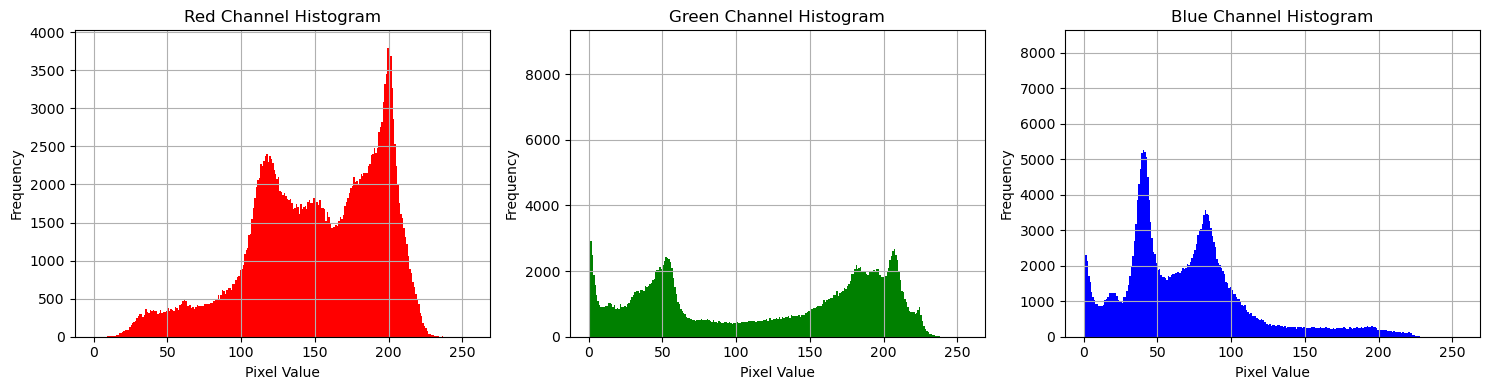

In [36]:
import matplotlib.pyplot as plt
from skimage import data

# Load the sample image
img=plt.imread("peppers.jpg") # shape: (512, 512, 3)

# Split the image into R, G, B channels
r_channel = img[:, :, 0]
g_channel = img[:, :, 1]
b_channel = img[:, :, 2]

# Create subplots
plt.figure(figsize=(15, 4))

# Red channel histogram
plt.subplot(1, 3, 1)
plt.hist(r_channel.ravel(), bins=256, range=[0, 256], color='red')
plt.title("Red Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Green channel histogram
plt.subplot(1, 3, 2)
plt.hist(g_channel.ravel(), bins=256, range=[0, 256], color='green')
plt.title("Green Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Blue channel histogram
plt.subplot(1, 3, 3)
plt.hist(b_channel.ravel(), bins=256, range=[0, 256], color='blue')
plt.title("Blue Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Show all plots
plt.tight_layout()
plt.show()



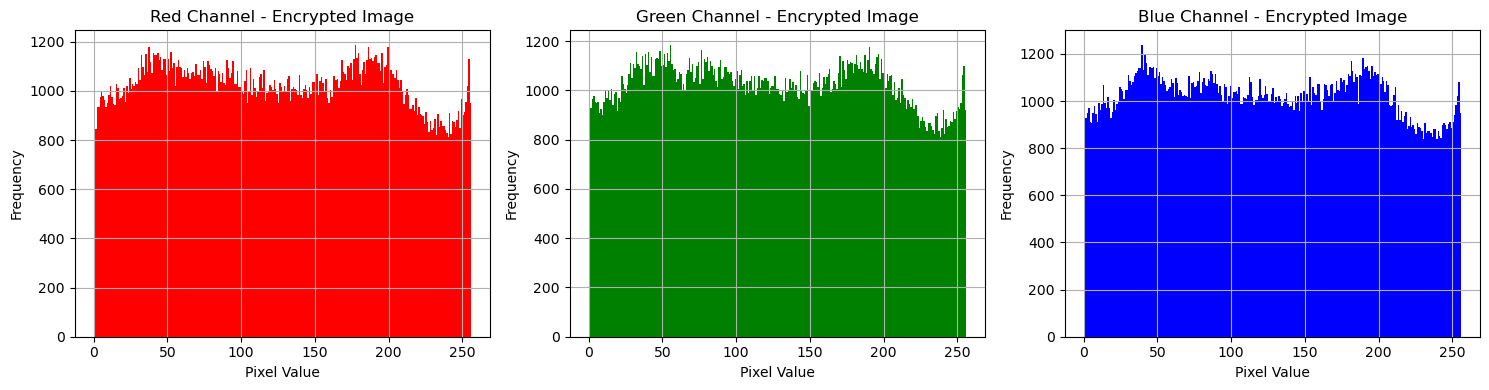

In [37]:
# Split the encrypted image into R, G, B channels
r_enc =  encrypted_image[:, :, 0]
g_enc =  encrypted_image[:, :, 1]
b_enc =  encrypted_image[:, :, 2]

# Create subplots for each channel
plt.figure(figsize=(15, 4))

# Red channel histogram
plt.subplot(1, 3, 1)
plt.hist(r_enc.ravel(), bins=256, range=[0, 256], color='red')
plt.title("Red Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Green channel histogram
plt.subplot(1, 3, 2)
plt.hist(g_enc.ravel(), bins=256, range=[0, 256], color='green')
plt.title("Green Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Blue channel histogram
plt.subplot(1, 3, 3)
plt.hist(b_enc.ravel(), bins=256, range=[0, 256], color='blue')
plt.title("Blue Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()

# Lena

In [38]:
img=plt.imread("lena.jpg")

In [39]:
img_flat = img.flatten()

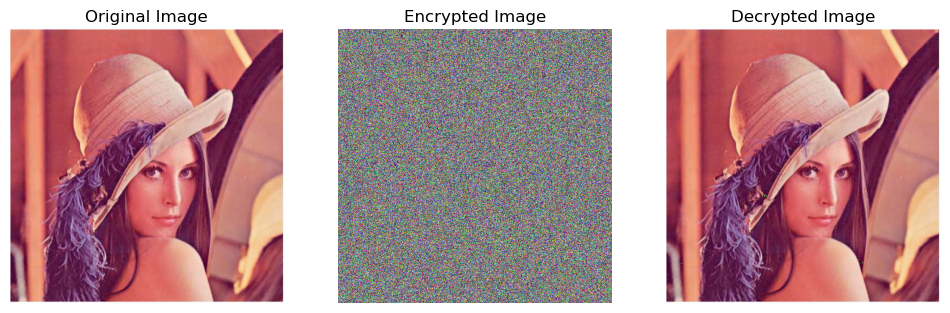

In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Logistic Map Generator
def logistic_map(x0, r, size):
    sequence = np.zeros(size)
    sequence[0] = x0
    for i in range(1, size):
        sequence[i] = r * sequence[i - 1] * (1 - sequence[i - 1])
    return sequence

# Image Encryption Function
def encrypt_image(image, x0, r):
    rows, cols, channels = image.shape
    total_pixels = rows * cols * channels

    # Generate chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Create index for shuffling (Confusion)
    shuffled_indices = np.argsort(chaotic_sequence)

    # Flatten image for easy processing
    flat_image = image.flatten()

    # Apply confusion (pixel shuffling)
    shuffled_image = flat_image[shuffled_indices]

    # Diffusion: Modify pixel values using chaotic sequence
    diffused_image = (shuffled_image + (chaotic_sequence * 255)) % 256
    diffused_image = diffused_image.astype(np.uint8)

    # Reshape to original image dimensions
    encrypted_image = diffused_image.reshape((rows, cols, channels))
    return encrypted_image, shuffled_indices

# Image Decryption Function
def decrypt_image(encrypted_image, shuffled_indices, x0, r):
    rows, cols, channels = encrypted_image.shape
    total_pixels = rows * cols * channels

    # Regenerate the same chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Flatten encrypted image
    flat_encrypted = encrypted_image.flatten()

    # Reverse diffusion
    recovered_diffused = (flat_encrypted - (chaotic_sequence * 255)) % 256

    # Reverse confusion (unshuffle pixels)
    unshuffled_image = np.zeros(total_pixels)
    unshuffled_image[shuffled_indices] = recovered_diffused

    # Reshape to original image
    decrypted_image = unshuffled_image.reshape((rows, cols, channels)).astype(np.uint8)
    return decrypted_image

# Load image
img=plt.imread("lena.jpg")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Encryption parameters
x0 = 0.7  # Initial condition
r = 3.99  # Control parameter
size=int(len(flat_img)/4)
rows, cols, channels = img.shape
total_pixels = rows * cols * channels  # Example: 512*512*3 = 786432

# Generate logistic chaotic sequence of required size
key_sequence = logistic_map(x0, r, total_pixels)

# Convert to key in range [0, 255]
key = np.floor(key_sequence * 256).astype(np.uint8)

# Flatten image
flat_img = img.flatten()
# Encrypt the image
encrypted_image, indices = encrypt_image(img, x0, r)

# Decrypt the image
decrypted_image = decrypt_image(encrypted_image, indices, x0, r)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Encrypted Image')
plt.imshow(encrypted_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Decrypted Image')
plt.imshow(decrypted_image)
plt.axis('off')

plt.show()

In [41]:
import math
from collections import Counter

def calculate_entropy_from_array(img_array):
    def entropy(channel_data):
        flat = channel_data.flatten()
        counts = Counter(flat)
        total = len(flat)
        return -sum((count / total) * math.log2(count / total) for count in counts.values())

    if img_array.ndim == 2:  # Grayscale image
        ent = entropy(img_array)
        print(f"Entropy: {ent:.4f} bits")
    elif img_array.ndim == 3 and img_array.shape[2] == 3:  # RGB image
        r_ent = entropy(img_array[:, :, 0])
        g_ent = entropy(img_array[:, :, 1])
        b_ent = entropy(img_array[:, :, 2])
        print(f"Red Channel Entropy   : {r_ent:.4f} bits")
        print(f"Green Channel Entropy : {g_ent:.4f} bits")
        print(f"Blue Channel Entropy  : {b_ent:.4f} bits")
        avg_ent = (r_ent + g_ent + b_ent) / 3
        print(f"Average Entropy       : {avg_ent:.4f} bits")
    else:
        raise ValueError("Unsupported image format")


# After XOR encryption:
# encrypted_img = encrypted_flat.reshape(img.shape)
calculate_entropy_from_array(encrypted_image)


Red Channel Entropy   : 7.9905 bits
Green Channel Entropy : 7.9905 bits
Blue Channel Entropy  : 7.9902 bits
Average Entropy       : 7.9904 bits


In [42]:
from math import log10

def calculate_npcr(img1, img2):
    return np.sum(img1 != img2) / img1.size * 100

def calculate_uaci(img1, img2):
    diff = np.abs(img1.astype(np.int32) - img2.astype(np.int32))
    return np.mean(diff / 255.0) * 100

def calculate_psnr(img1, img2):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf'), mse
    psnr = 10 * log10((255.0 ** 2) / mse)
    return psnr, mse

def evaluate_encryption_metrics(img, encrypted_img):
    if img.ndim == 3:  # RGB image
        npcr_total, uaci_total, psnr_total, mse_total = 0, 0, 0, 0
        for c in range(3):
            npcr = calculate_npcr(img[:, :, c], encrypted_img[:, :, c])
            uaci = calculate_uaci(img[:, :, c], encrypted_img[:, :, c])
            psnr, mse = calculate_psnr(img[:, :, c], encrypted_img[:, :, c])
            print(f"Channel {c} - NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB, MSE: {mse:.2f}")
            npcr_total += npcr
            uaci_total += uaci
            psnr_total += psnr
            mse_total += mse
        print(f"Average - NPCR: {npcr_total/3:.2f}%, UACI: {uaci_total/3:.2f}%, PSNR: {psnr_total/3:.2f} dB, MSE: {mse_total/3:.2f}")
    else:  # Grayscale
        npcr = calculate_npcr(img, encrypted_img)
        uaci = calculate_uaci(img, encrypted_img)
        psnr, mse = calculate_psnr(img, encrypted_img)
        print(f"NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB, MSE: {mse:.2f}")
# evaluate_encryption_metrics(original_img, encrypted_img)
evaluate_encryption_metrics(img, encrypted_image)

Channel 0 - NPCR: 99.59%, UACI: 32.71%, PSNR: 7.97 dB, MSE: 10386.24
Channel 1 - NPCR: 99.61%, UACI: 29.74%, PSNR: 8.76 dB, MSE: 8642.54
Channel 2 - NPCR: 99.56%, UACI: 26.54%, PSNR: 9.85 dB, MSE: 6728.71
Average - NPCR: 99.59%, UACI: 29.66%, PSNR: 8.86 dB, MSE: 8585.83


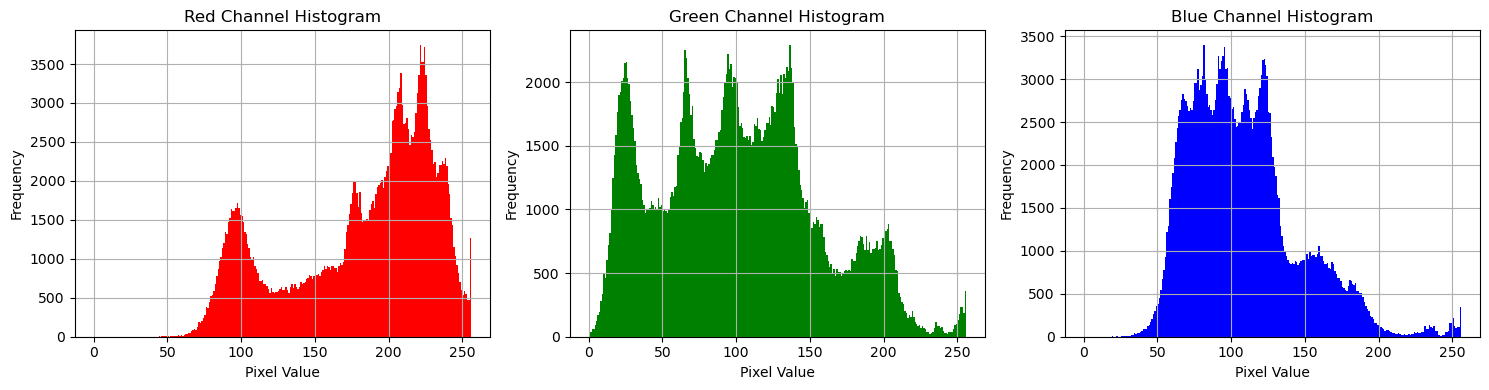

In [43]:
import matplotlib.pyplot as plt
from skimage import data

# Load the sample image
img=plt.imread("lena.jpg") # shape: (512, 512, 3)

# Split the image into R, G, B channels
r_channel = img[:, :, 0]
g_channel = img[:, :, 1]
b_channel = img[:, :, 2]

# Create subplots
plt.figure(figsize=(15, 4))

# Red channel histogram
plt.subplot(1, 3, 1)
plt.hist(r_channel.ravel(), bins=256, range=[0, 256], color='red')
plt.title("Red Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Green channel histogram
plt.subplot(1, 3, 2)
plt.hist(g_channel.ravel(), bins=256, range=[0, 256], color='green')
plt.title("Green Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Blue channel histogram
plt.subplot(1, 3, 3)
plt.hist(b_channel.ravel(), bins=256, range=[0, 256], color='blue')
plt.title("Blue Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Show all plots
plt.tight_layout()
plt.show()



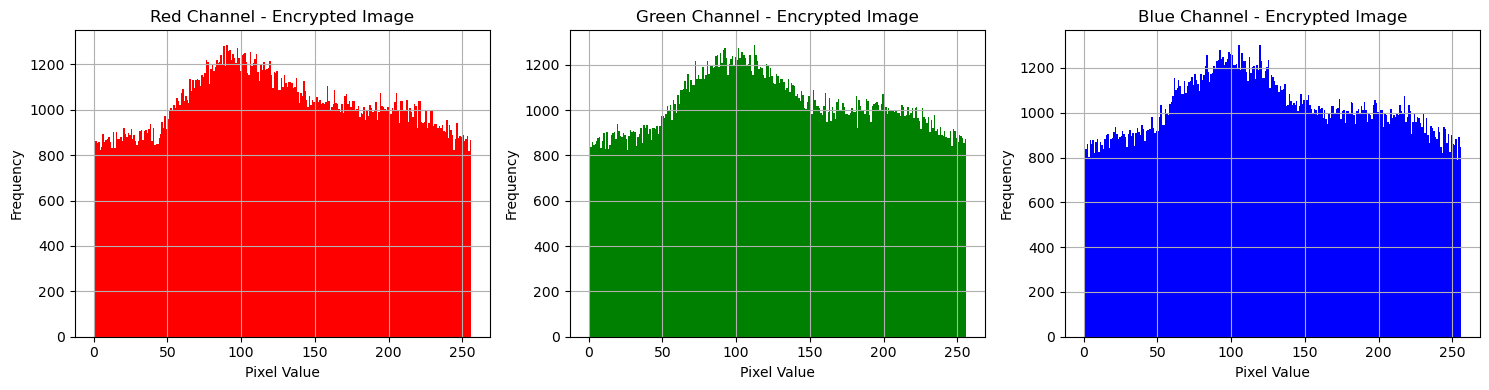

In [44]:
# Split the encrypted image into R, G, B channels
r_enc =  encrypted_image[:, :, 0]
g_enc =  encrypted_image[:, :, 1]
b_enc =  encrypted_image[:, :, 2]

# Create subplots for each channel
plt.figure(figsize=(15, 4))

# Red channel histogram
plt.subplot(1, 3, 1)
plt.hist(r_enc.ravel(), bins=256, range=[0, 256], color='red')
plt.title("Red Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Green channel histogram
plt.subplot(1, 3, 2)
plt.hist(g_enc.ravel(), bins=256, range=[0, 256], color='green')
plt.title("Green Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Blue channel histogram
plt.subplot(1, 3, 3)
plt.hist(b_enc.ravel(), bins=256, range=[0, 256], color='blue')
plt.title("Blue Channel - Encrypted Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()

# Baboon

In [45]:
img=plt.imread("baboon.jpg")

In [46]:
img_flat = img.flatten()

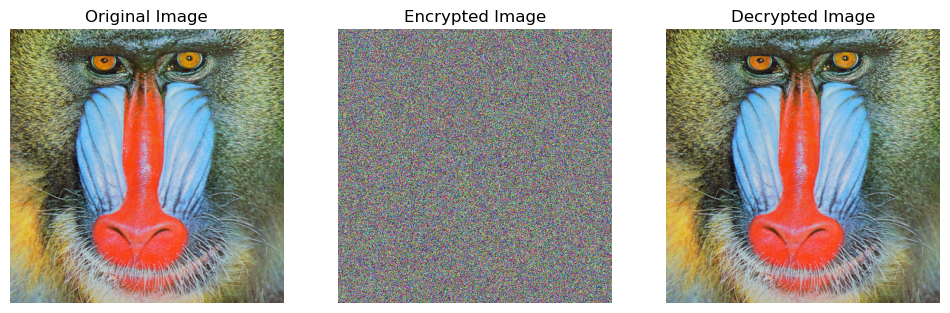

In [47]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Logistic Map Generator
def logistic_map(x0, r, size):
    sequence = np.zeros(size)
    sequence[0] = x0
    for i in range(1, size):
        sequence[i] = r * sequence[i - 1] * (1 - sequence[i - 1])
    return sequence

# Image Encryption Function
def encrypt_image(image, x0, r):
    rows, cols, channels = image.shape
    total_pixels = rows * cols * channels

    # Generate chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Create index for shuffling (Confusion)
    shuffled_indices = np.argsort(chaotic_sequence)

    # Flatten image for easy processing
    flat_image = image.flatten()

    # Apply confusion (pixel shuffling)
    shuffled_image = flat_image[shuffled_indices]

    # Diffusion: Modify pixel values using chaotic sequence
    diffused_image = (shuffled_image + (chaotic_sequence * 255)) % 256
    diffused_image = diffused_image.astype(np.uint8)

    # Reshape to original image dimensions
    encrypted_image = diffused_image.reshape((rows, cols, channels))
    return encrypted_image, shuffled_indices

# Image Decryption Function
def decrypt_image(encrypted_image, shuffled_indices, x0, r):
    rows, cols, channels = encrypted_image.shape
    total_pixels = rows * cols * channels

    # Regenerate the same chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Flatten encrypted image
    flat_encrypted = encrypted_image.flatten()

    # Reverse diffusion
    recovered_diffused = (flat_encrypted - (chaotic_sequence * 255)) % 256

    # Reverse confusion (unshuffle pixels)
    unshuffled_image = np.zeros(total_pixels)
    unshuffled_image[shuffled_indices] = recovered_diffused

    # Reshape to original image
    decrypted_image = unshuffled_image.reshape((rows, cols, channels)).astype(np.uint8)
    return decrypted_image
img=plt.imread("baboon.jpg")
x0 = 0.7  # Initial condition
r = 3.99  # Control parameter
size=int(len(img_flat)/4)
rows, cols, channels = img.shape
total_pixels = rows * cols * channels  # Example: 512*512*3 = 786432

# Generate logistic chaotic sequence of required size
key_sequence = logistic_map(x0, r, total_pixels)

# Convert to key in range [0, 255]
key = np.floor(key_sequence * 256).astype(np.uint8)

# Flatten image
flat_img = img.flatten()
# Encrypt the image
encrypted_image, indices = encrypt_image(img, x0, r)

# Decrypt the image
decrypted_image = decrypt_image(encrypted_image, indices, x0, r)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Encrypted Image')
plt.imshow(encrypted_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Decrypted Image')
plt.imshow(decrypted_image)
plt.axis('off')

plt.show()

plt.show()

In [48]:
import numpy as np
import math
from collections import Counter

def calculate_entropy_from_array(img_array):
    def entropy(channel_data):
        flat = channel_data.flatten()
        counts = Counter(flat)
        total = len(flat)
        return -sum((count / total) * math.log2(count / total) for count in counts.values())

    if img_array.ndim == 2:  # Grayscale image
        ent = entropy(img_array)
        print(f"Entropy: {ent:.4f} bits")
    elif img_array.ndim == 3 and img_array.shape[2] == 3:  # RGB image
        r_ent = entropy(img_array[:, :, 0])
        g_ent = entropy(img_array[:, :, 1])
        b_ent = entropy(img_array[:, :, 2])
        print(f"Red Channel Entropy   : {r_ent:.4f} bits")
        print(f"Green Channel Entropy : {g_ent:.4f} bits")
        print(f"Blue Channel Entropy  : {b_ent:.4f} bits")
        avg_ent = (r_ent + g_ent + b_ent) / 3
        print(f"Average Entropy       : {avg_ent:.4f} bits")
    else:
        raise ValueError("Unsupported image format")


# After XOR encryption:
# encrypted_img = encrypted_flat.reshape(img.shape)
calculate_entropy_from_array(encrypted_image)


Red Channel Entropy   : 7.9874 bits
Green Channel Entropy : 7.9868 bits
Blue Channel Entropy  : 7.9870 bits
Average Entropy       : 7.9871 bits


In [49]:
import numpy as np
import cv2
from math import log10

def calculate_npcr(img1, img2):
    return np.sum(img1 != img2) / img1.size * 100

def calculate_uaci(img1, img2):
    diff = np.abs(img1.astype(np.int32) - img2.astype(np.int32))
    return np.mean(diff / 255.0) * 100

def calculate_psnr(img1, img2):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf'), mse
    psnr = 10 * log10((255.0 ** 2) / mse)
    return psnr, mse

def evaluate_encryption_metrics(img, encrypted_img):
    if img.ndim == 3:  # RGB image
        npcr_total, uaci_total, psnr_total, mse_total = 0, 0, 0, 0
        for c in range(3):
            npcr = calculate_npcr(img[:, :, c], encrypted_img[:, :, c])
            uaci = calculate_uaci(img[:, :, c], encrypted_img[:, :, c])
            psnr, mse = calculate_psnr(img[:, :, c], encrypted_img[:, :, c])
            print(f"Channel {c} - NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB, MSE: {mse:.2f}")
            npcr_total += npcr
            uaci_total += uaci
            psnr_total += psnr
            mse_total += mse
        print(f"Average - NPCR: {npcr_total/3:.2f}%, UACI: {uaci_total/3:.2f}%, PSNR: {psnr_total/3:.2f} dB, MSE: {mse_total/3:.2f}")
    else:  # Grayscale
        npcr = calculate_npcr(img, encrypted_img)
        uaci = calculate_uaci(img, encrypted_img)
        psnr, mse = calculate_psnr(img, encrypted_img)
        print(f"NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB, MSE: {mse:.2f}")

# Example usage:
# evaluate_encryption_metrics(original_img, encrypted_img)
evaluate_encryption_metrics(img, encrypted_image)


Channel 0 - NPCR: 99.59%, UACI: 28.70%, PSNR: 9.09 dB, MSE: 8013.18
Channel 1 - NPCR: 99.58%, UACI: 27.04%, PSNR: 9.68 dB, MSE: 7002.56
Channel 2 - NPCR: 99.61%, UACI: 29.85%, PSNR: 8.72 dB, MSE: 8729.34
Average - NPCR: 99.59%, UACI: 28.53%, PSNR: 9.16 dB, MSE: 7915.03


# Tulip 

In [50]:
img=plt.imread("tulips.jpg")
img_flat = img.flatten()

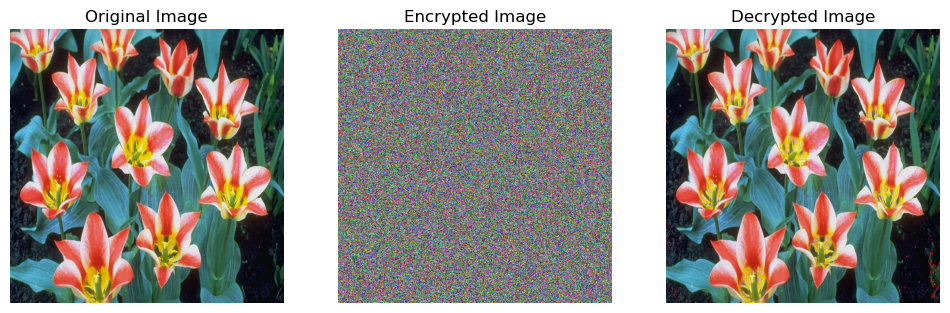

In [51]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Logistic Map Generator
def logistic_map(x0, r, size):
    sequence = np.zeros(size)
    sequence[0] = x0
    for i in range(1, size):
        sequence[i] = r * sequence[i - 1] * (1 - sequence[i - 1])
    return sequence

# Image Encryption Function
def encrypt_image(image, x0, r):
    rows, cols, channels = image.shape
    total_pixels = rows * cols * channels

    # Generate chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Create index for shuffling (Confusion)
    shuffled_indices = np.argsort(chaotic_sequence)

    # Flatten image for easy processing
    flat_image = image.flatten()

    # Apply confusion (pixel shuffling)
    shuffled_image = flat_image[shuffled_indices]

    # Diffusion: Modify pixel values using chaotic sequence
    diffused_image = (shuffled_image + (chaotic_sequence * 255)) % 256
    diffused_image = diffused_image.astype(np.uint8)

    # Reshape to original image dimensions
    encrypted_image = diffused_image.reshape((rows, cols, channels))
    return encrypted_image, shuffled_indices

# Image Decryption Function
def decrypt_image(encrypted_image, shuffled_indices, x0, r):
    rows, cols, channels = encrypted_image.shape
    total_pixels = rows * cols * channels

    # Regenerate the same chaotic sequence
    chaotic_sequence = logistic_map(x0, r, total_pixels)

    # Flatten encrypted image
    flat_encrypted = encrypted_image.flatten()

    # Reverse diffusion
    recovered_diffused = (flat_encrypted - (chaotic_sequence * 255)) % 256

    # Reverse confusion (unshuffle pixels)
    unshuffled_image = np.zeros(total_pixels)
    unshuffled_image[shuffled_indices] = recovered_diffused

    # Reshape to original image
    decrypted_image = unshuffled_image.reshape((rows, cols, channels)).astype(np.uint8)
    return decrypted_image
img=plt.imread("tulips.jpg")
x0 = 0.7  # Initial condition
r = 3.99  # Control parameter
size=int(len(img_flat)/4)
rows, cols, channels = img.shape
total_pixels = rows * cols * channels  # Example: 512*512*3 = 786432

# Generate logistic chaotic sequence of required size
key_sequence = logistic_map(x0, r, total_pixels)

# Convert to key in range [0, 255]
key = np.floor(key_sequence * 256).astype(np.uint8)

# Flatten image
flat_img = img.flatten()
# Encrypt the image
encrypted_image, indices = encrypt_image(img, x0, r)

# Decrypt the image
decrypted_image = decrypt_image(encrypted_image, indices, x0, r)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Encrypted Image')
plt.imshow(encrypted_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Decrypted Image')
plt.imshow(decrypted_image)
plt.axis('off')

plt.show()


In [52]:
import numpy as np
import math
from collections import Counter

def calculate_entropy_from_array(img_array):
    def entropy(channel_data):
        flat = channel_data.flatten()
        counts = Counter(flat)
        total = len(flat)
        return -sum((count / total) * math.log2(count / total) for count in counts.values())

    if img_array.ndim == 2:  # Grayscale image
        ent = entropy(img_array)
        print(f"Entropy: {ent:.4f} bits")
    elif img_array.ndim == 3 and img_array.shape[2] == 3:  # RGB image
        r_ent = entropy(img_array[:, :, 0])
        g_ent = entropy(img_array[:, :, 1])
        b_ent = entropy(img_array[:, :, 2])
        print(f"Red Channel Entropy   : {r_ent:.4f} bits")
        print(f"Green Channel Entropy : {g_ent:.4f} bits")
        print(f"Blue Channel Entropy  : {b_ent:.4f} bits")
        avg_ent = (r_ent + g_ent + b_ent) / 3
        print(f"Average Entropy       : {avg_ent:.4f} bits")
    else:
        raise ValueError("Unsupported image format")


# After XOR encryption:
# encrypted_img = encrypted_flat.reshape(img.shape)
calculate_entropy_from_array(encrypted_image)

Red Channel Entropy   : 7.9912 bits
Green Channel Entropy : 7.9915 bits
Blue Channel Entropy  : 7.9912 bits
Average Entropy       : 7.9913 bits


In [53]:
import numpy as np
import cv2
from math import log10

def calculate_npcr(img1, img2):
    return np.sum(img1 != img2) / img1.size * 100

def calculate_uaci(img1, img2):
    diff = np.abs(img1.astype(np.int32) - img2.astype(np.int32))
    return np.mean(diff / 255.0) * 100

def calculate_psnr(img1, img2):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf'), mse
    psnr = 10 * log10((255.0 ** 2) / mse)
    return psnr, mse

def evaluate_encryption_metrics(img, encrypted_img):
    if img.ndim == 3:  # RGB image
        npcr_total, uaci_total, psnr_total, mse_total = 0, 0, 0, 0
        for c in range(3):
            npcr = calculate_npcr(img[:, :, c], encrypted_img[:, :, c])
            uaci = calculate_uaci(img[:, :, c], encrypted_img[:, :, c])
            psnr, mse = calculate_psnr(img[:, :, c], encrypted_img[:, :, c])
            print(f"Channel {c} - NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB, MSE: {mse:.2f}")
            npcr_total += npcr
            uaci_total += uaci
            psnr_total += psnr
            mse_total += mse
        print(f"Average - NPCR: {npcr_total/3:.2f}%, UACI: {uaci_total/3:.2f}%, PSNR: {psnr_total/3:.2f} dB, MSE: {mse_total/3:.2f}")
    else:  # Grayscale
        npcr = calculate_npcr(img, encrypted_img)
        uaci = calculate_uaci(img, encrypted_img)
        psnr, mse = calculate_psnr(img, encrypted_img)
        print(f"NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%, PSNR: {psnr:.2f} dB, MSE: {mse:.2f}")

# Example usage:
# evaluate_encryption_metrics(original_img, encrypted_img)
evaluate_encryption_metrics(img, encrypted_image)


Channel 0 - NPCR: 99.59%, UACI: 36.05%, PSNR: 7.07 dB, MSE: 12776.60
Channel 1 - NPCR: 99.59%, UACI: 31.09%, PSNR: 8.39 dB, MSE: 9426.65
Channel 2 - NPCR: 99.58%, UACI: 32.07%, PSNR: 8.05 dB, MSE: 10184.29
Average - NPCR: 99.58%, UACI: 33.07%, PSNR: 7.84 dB, MSE: 10795.85


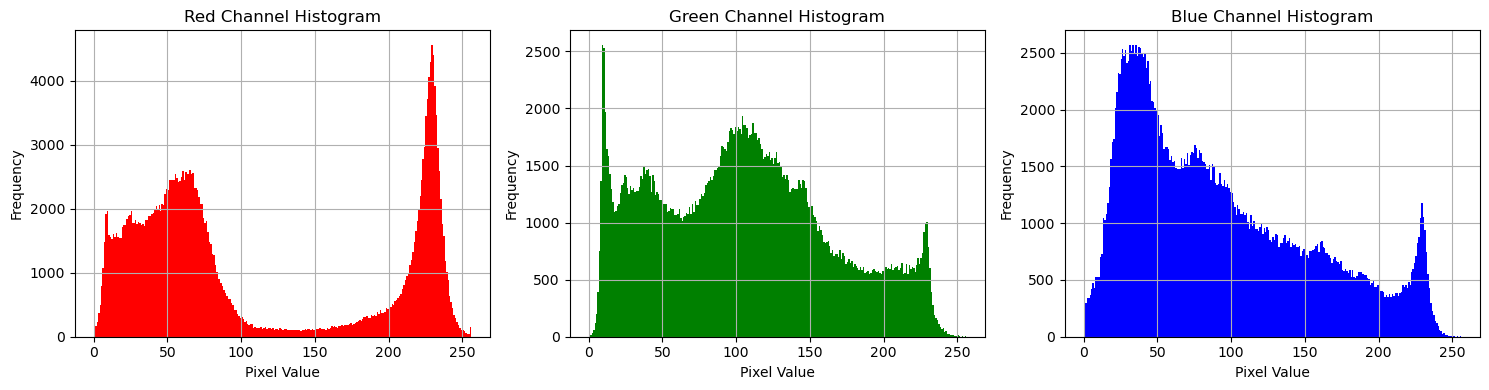

In [54]:

# Load the sample image
img=plt.imread("tulips.jpg")# shape: (512, 512, 3)

# Split the image into R, G, B channels
r_channel = img[:, :, 0]
g_channel = img[:, :, 1]
b_channel = img[:, :, 2]

# Create subplots
plt.figure(figsize=(15, 4))

# Red channel histogram
plt.subplot(1, 3, 1)
plt.hist(r_channel.ravel(), bins=256, range=[0, 256], color='red')
plt.title("Red Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Green channel histogram
plt.subplot(1, 3, 2)
plt.hist(g_channel.ravel(), bins=256, range=[0, 256], color='green')
plt.title("Green Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Blue channel histogram
plt.subplot(1, 3, 3)
plt.hist(b_channel.ravel(), bins=256, range=[0, 256], color='blue')
plt.title("Blue Channel Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)

# Show all plots
plt.tight_layout()
plt.show()

